In [4]:
import numpy as np
from numpy.fft import rfft
from scipy.io.wavfile import read as wavread
import matplotlib.pyplot as plt
from numbers import Number

class LTSA():
    '''
    Long-Term Spectral Average base class
    Abstract -- do not instantiate. Subclasses should implement a constructor
    at minimum. Constructors of derived classes are responsible for getting the
    raw audio data into self.signal
    Methods implement an algorithm for computing spectral visualizations of
    long audio signals.
    See WavLTSA, RawLTSA for concrete classes implementing the LTSA
    '''

# takes a dict of attribute name/value pairs and sets LTSA params accordingly
    def set_params(self, var_dict):
        '''
        Allows the user to set custom values for computation parameters.
        It is recommended that only these variables be manipulated:
            div_len
            subdiv_len
            nfft
            noverlap
        Example input:
        var_dict = {'div_len':8192, 'subdiv_len':1024}
        
        *var_dict*
        Dictionary containing names and values of parameters to set
        '''
        for key, val in var_dict.items():
            vars(self)[key] = val

        self._set_nvals()

    def crop(self, tmin=0, tmax=None, fmin=0, fmax=None):
        '''
        Crop the computed LTSA in time and/or frequency. Anything that is
        cropped out is thrown away and will need to be recomputed if needed.
        This method returns the indices that were computed and used for
        cropping for testing purposes
        *tmin*
        beginning of time region which will not be cropped out
        *tmax*
        end of time region which will not be cropped out
        *fmin*
        lower range of frequencies which will not be cropped out
        *fmax*
        upper range of frequencies which will not be cropped out
        '''
        # workaround for not being able to use "self" in default arguments
        if tmax is None:
            tmax = self.tmax
        if fmax is None:
            fmax = self.fmax

        # check inputs are all real numbers
        inputs = [tmin, tmax, fmin, fmax]
        for val in inputs:
            if not (isinstance(val, Number) and np.isreal(val)):
                raise TypeError('all inputs must be real numbers')

        # check for input sanity
        if tmin < self.tmin or tmax <= tmin or tmax < 0:
            raise ValueError('tmin (%.3f) and/or tmax (%.3f) out of range' % (tmin, tmax))
        if fmin < self.fmin or fmax <= fmin or fmax < 0:
            raise ValueError('fmin (%.3f) and/or fmax (%.3f) out of range' % (fmin, fmax))

        # update time and frequency limits
        self.tmin = tmin
        self.tmax = tmax
        self.fmin = fmin
        self.fmax = fmax

        # crop time axis
        divs_per_second = self.fs / self.div_len
        div_low = int(np.floor(tmin * divs_per_second))
        div_high = int(np.ceil(tmax * divs_per_second)) + 1
        self.ltsa = self.ltsa[:, div_low:div_high]

        # crop frequency axis
        pixels_per_hz = self.ltsa.shape[0] / (self.fs/2)
        freq_low = int(np.floor(fmin * pixels_per_hz))
        freq_high = int(np.ceil(fmax * pixels_per_hz)) + 1
        self.ltsa = self.ltsa[freq_low:freq_high, :]

        return div_low, div_high, freq_low, freq_high

        
    def _set_nvals(self):
        '''
        Computes and sets the nsamples, ndivs, and nsubdivs attributes
        '''
        self.nsamples = self.signal.size
        self.ndivs = int(np.floor(self.nsamples / self.div_len))
        self.nsubdivs = int(np.floor(self.div_len / (self.subdiv_len - self.noverlap)))

    def _init_params(self):
        '''
        Initialize some useful class attributes to default values, including
        the parameters that govern the LTSA computation and the show and crop
        methods.
        This method should be run by the constructor once the signal data and
        sampling frequency have been populated. 
        '''
        # defaults for LTSA algorithm parameters
        self.div_len = int(np.round(self.fs/2)) # half second divisions
        self.subdiv_len = int(2**np.round(np.log2(self.fs/5)))
        self.nfft = None # will be checked and assigned in the compute method
        self.noverlap = 0

        self._set_nvals()

        # time and frequency limits, used for displaying results
        self.tmin = 0
        self.tmax = np.floor(self.nsamples / self.fs)
        self.fmin = 0
        self.fmax = np.floor(self.fs / 2)

    def show(self, resize=None, interp='bilinear'):
        '''
        Displays the LTSA image in the current axis using
        matplotlib.pyplot.imshow(). It is often useful to manually adjust the
        color axis using pyplot.clim(), as the default clim is usually wider
        than it should be
        *resize*
        This argument controls what image resizing will be applied to the ltsa
        array before it is displayed. There are several possible types that can
        be passed as resize depending on the desired behavior:
            
            None
            No resizing action is taken
            (int, int)
            scipy.misc.imresize is called -> imresize(self.ltsa, resize, interp)
            int
            The frequency axis is downsampled such that it's length is resize.
            Currently this uses no lowpass filtering or interpolation so the
            results may show some jaggedness but it is not typically a problem
        *interp*
        Only used when imresize is called. Determines the type of interpolation
        used in resizing. See the scipy.misc.imresize function for more
        information.
        '''
        if isinstance(resize, tuple) and len(resize) == 2:
            #img = imresize(self.ltsa, resize, interp)

            import PIL
            pimg = PIL.Image.fromarray(self.ltsa)
            pimg = pimg.resize(resize, resample=interp)
            img = np.asarray(pimg)

        elif isinstance(resize, int):
            # downsample (without lowpass filtering)
            if resize < 1 or resize > self.ltsa.shape[0]:
                raise ValueError('resize out of range: %s' % str(resize))

            h = resize # img height in pixels
            idx = np.floor(np.linspace(0, np.size(self.ltsa, 0)-1, h))
            idx = np.int32(idx)
            img = np.zeros((h, np.size(self.ltsa, 1)))
            for i in range(int(np.size(self.ltsa, 1))):
                img[:,i] = self.ltsa[idx,i] 

        elif resize is None:
            img = self.ltsa

        else:
            raise TypeError('resize not of acceptable type: %s' % str(resize))

        # set correct labels on image
        ext = (self.tmin, self.tmax, self.fmin, self.fmax)
        self.handle = plt.imshow(img, origin='lower', extent=ext, aspect='auto')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Frequency (Hertz)')

        return img

    def __call__(self):
        '''
        Calling an LTSA instance directly is identical to calling compute()
        '''
        self.compute()

    def compute(self): 
        '''
        This method executes the LTSA algorithm. The result is a grayscale
        image (2D numpy array) which is assigned to the self.ltsa attribute. 
        All the data that this method needs is provided ahead of time by the
        constructor and/or the set_params method.
        A syntactic shortcut for calling this method is to simply call the LTSA
        object with no arguments.
        '''

        if self.nfft is None:
            self.nfft = int(self.subdiv_len)
        self.signal = self.signal[: self.ndivs * self.div_len]
        self.tmax = len(self.signal) / self.fs
        self.ltsa = np.zeros((self.nfft//2, self.ndivs), dtype=np.single)
        divs = np.reshape(self.signal, (self.ndivs, self.div_len)).T

        for i in range(int(self.ndivs)):
            div = divs[:,i]
            self.ltsa[:,i] = self._calc_spectrum(div)

    def _calc_spectrum(self, div):
        '''
        This function is used by compute() to determine the approximate
        frequency content of one division of audio data. 
        '''
        spectrum = np.zeros((self.nfft//2,))
        window = np.hanning(self.subdiv_len)
        slip = self.subdiv_len - self.noverlap
        if slip <= 0:
            raise ValueError('overlap exceeds subdiv_len, slip = %s' % str(slip))

        lo = 0
        hi = self.subdiv_len
        nsubdivs = 0
        while hi < self.div_len:
            nsubdivs += 1
            subdiv = div[lo:hi]
            tr = rfft(subdiv * window, int(self.nfft))
            spectrum += np.abs(tr[:self.nfft//2])
            lo += slip
            hi += slip

        spectrum = np.single(np.log(spectrum / self.nsubdivs))
        return spectrum

    def scale_to_uint8(self): 
        '''
        Rescales self.ltsa to fit into unsigned 8 bit integers and converts the
        data type of self.ltsa to np.uint8
        '''
        self.ltsa -= self.ltsa.min()
        self.ltsa *= 255 / self.ltsa.max()
        self.ltsa = np.uint8(self.ltsa)

    def __getitem__(self, key):
        '''
        Provides access to the elements of self.ltsa
        '''
        return self.ltsa[key]

    def __setitem__(self, key, value):
        '''
        Allows easy setting of the elements of self.ltsa
        '''
        self.ltsa[key] = value

    def __eq__(self, other):
        '''
        Equality is tested by checking the computed self.ltsa arrays. All
        elements of self.ltsa must equal the corresponding element in
        other.ltsa for equality.  
        Equality testing will return False unless it can verify that 
        self.ltsa == other.ltsa 
        '''
        try:
            return (self.ltsa == other.ltsa).all()
        except:
            return False

    def __ne__(self, other):
        '''
        Returns the opposite of __eq__
        '''
        return not self.__eq__(self, other)
    
class WavLTSA(LTSA):
    '''
    Long-Term Spectral Average
    A class for computing spectral visualizations of long audio signals.
    Inputs:
    *_file*
    Path to a .wav file to be processed. The entire file will be read in at
    once, so for files too large to fit in memory, split them up or handle them
    piecewise with RawLTSA
    *channel*
    Selects one channel from the wav file to process, defaults to 0
    The computation is run with compute() or __call__ and the resulting image
    is stored in the ltsa attribute. The crop() method crops the image to a
    specified time/frequency space. 
    show() displays the LTSA in the current figure using pyplot.imshow() and
    has optional resizing arguments.
    '''
    # initialize with default parameters
    def __init__(self, _file, channel=0):

        self.ltsa = None

        if isinstance(_file, str) and _file[-4:] == '.wav':
            self.fs, self.signal = wavread(_file)
            if self.signal.ndim > 1:
                self.signal = self.signal[:,channel] # take only one channel
        else:
            raise TypeError('Input is not a path to a .wav file: %s' % str(_file))

        self._init_params()


    
class RawLTSA(LTSA):
    '''
    Long-Term Spectral Average
    A class for computing spectral visualizations of long audio signals.
    Inputs:
    *raw*
    One-dimensional, real numpy array containing the raw audio data
    *fs*
    Sampling frequency in Hertz, defaults to 44100
    The computation is run with compute() or __call__ and the resulting image
    is stored in the ltsa attribute. The crop() method crops the image to a
    specified time/frequency space. 
    show() displays the LTSA in the current figure using pyplot.imshow() and
    has optional resizing arguments.
    '''
    # initialize with default parameters
    def __init__(self, raw, fs=44100):
        self.ltsa = None
        if not isinstance(raw, np.ndarray) or raw.ndim != 1:
            raise TypeError('Input is not a one-dimensional numpy array')
        else:
            self.signal = raw
            self.fs = fs

        self._init_params()


import numpy as np
from numpy.fft import rfft
from scipy.io.wavfile import read as wavread
import matplotlib.pyplot as plt
from numbers import Number

class LTSA():
    '''
    Long-Term Spectral Average base class
    Abstract -- do not instantiate. Subclasses should implement a constructor
    at minimum. Constructors of derived classes are responsible for getting the
    raw audio data into self.signal
    Methods implement an algorithm for computing spectral visualizations of
    long audio signals.
    See WavLTSA, RawLTSA for concrete classes implementing the LTSA
    '''

# takes a dict of attribute name/value pairs and sets LTSA params accordingly
    def set_params(self, var_dict):
        '''
        Allows the user to set custom values for computation parameters.
        It is recommended that only these variables be manipulated:
            div_len
            subdiv_len
            nfft
            noverlap
        Example input:
        var_dict = {'div_len':8192, 'subdiv_len':1024}
        
        *var_dict*
        Dictionary containing names and values of parameters to set
        '''
        for key, val in var_dict.items():
            vars(self)[key] = val

        self._set_nvals()

    def crop(self, tmin=0, tmax=None, fmin=0, fmax=None):
        '''
        Crop the computed LTSA in time and/or frequency. Anything that is
        cropped out is thrown away and will need to be recomputed if needed.
        This method returns the indices that were computed and used for
        cropping for testing purposes
        *tmin*
        beginning of time region which will not be cropped out
        *tmax*
        end of time region which will not be cropped out
        *fmin*
        lower range of frequencies which will not be cropped out
        *fmax*
        upper range of frequencies which will not be cropped out
        '''
        # workaround for not being able to use "self" in default arguments
        if tmax is None:
            tmax = self.tmax
        if fmax is None:
            fmax = self.fmax

        # check inputs are all real numbers
        inputs = [tmin, tmax, fmin, fmax]
        for val in inputs:
            if not (isinstance(val, Number) and np.isreal(val)):
                raise TypeError('all inputs must be real numbers')

        # check for input sanity
        if tmin < self.tmin or tmax <= tmin or tmax < 0:
            raise ValueError('tmin (%.3f) and/or tmax (%.3f) out of range' % (tmin, tmax))
        if fmin < self.fmin or fmax <= fmin or fmax < 0:
            raise ValueError('fmin (%.3f) and/or fmax (%.3f) out of range' % (fmin, fmax))

        # update time and frequency limits
        self.tmin = tmin
        self.tmax = tmax
        self.fmin = fmin
        self.fmax = fmax

        # crop time axis
        divs_per_second = self.fs / self.div_len
        div_low = int(np.floor(tmin * divs_per_second))
        div_high = int(np.ceil(tmax * divs_per_second)) + 1
        self.ltsa = self.ltsa[:, div_low:div_high]

        # crop frequency axis
        pixels_per_hz = self.ltsa.shape[0] / (self.fs/2)
        freq_low = int(np.floor(fmin * pixels_per_hz))
        freq_high = int(np.ceil(fmax * pixels_per_hz)) + 1
        self.ltsa = self.ltsa[freq_low:freq_high, :]

        return div_low, div_high, freq_low, freq_high

        
    def _set_nvals(self):
        '''
        Computes and sets the nsamples, ndivs, and nsubdivs attributes
        '''
        self.nsamples = self.signal.size
        self.ndivs = int(np.floor(self.nsamples / self.div_len))
        self.nsubdivs = int(np.floor(self.div_len / (self.subdiv_len - self.noverlap)))

    def _init_params(self):
        '''
        Initialize some useful class attributes to default values, including
        the parameters that govern the LTSA computation and the show and crop
        methods.
        This method should be run by the constructor once the signal data and
        sampling frequency have been populated. 
        '''
        # defaults for LTSA algorithm parameters
        self.div_len = int(np.round(self.fs/2)) # half second divisions
        self.subdiv_len = int(2**np.round(np.log2(self.fs/5)))
        self.nfft = None # will be checked and assigned in the compute method
        self.noverlap = 0

        self._set_nvals()

        # time and frequency limits, used for displaying results
        self.tmin = 0
        self.tmax = np.floor(self.nsamples / self.fs)
        self.fmin = 0
        self.fmax = np.floor(self.fs / 2)

    def show(self, resize=None, interp='bilinear'):
        '''
        Displays the LTSA image in the current axis using
        matplotlib.pyplot.imshow(). It is often useful to manually adjust the
        color axis using pyplot.clim(), as the default clim is usually wider
        than it should be
        *resize*
        This argument controls what image resizing will be applied to the ltsa
        array before it is displayed. There are several possible types that can
        be passed as resize depending on the desired behavior:
            
            None
            No resizing action is taken
            (int, int)
            scipy.misc.imresize is called -> imresize(self.ltsa, resize, interp)
            int
            The frequency axis is downsampled such that it's length is resize.
            Currently this uses no lowpass filtering or interpolation so the
            results may show some jaggedness but it is not typically a problem
        *interp*
        Only used when imresize is called. Determines the type of interpolation
        used in resizing. See the scipy.misc.imresize function for more
        information.
        '''
        if isinstance(resize, tuple) and len(resize) == 2:
            #img = imresize(self.ltsa, resize, interp)

            import PIL
            pimg = PIL.Image.fromarray(self.ltsa)
            pimg = pimg.resize(resize, resample=interp)
            img = np.asarray(pimg)

        elif isinstance(resize, int):
            # downsample (without lowpass filtering)
            if resize < 1 or resize > self.ltsa.shape[0]:
                raise ValueError('resize out of range: %s' % str(resize))

            h = resize # img height in pixels
            idx = np.floor(np.linspace(0, np.size(self.ltsa, 0)-1, h))
            idx = np.int32(idx)
            img = np.zeros((h, np.size(self.ltsa, 1)))
            for i in range(int(np.size(self.ltsa, 1))):
                img[:,i] = self.ltsa[idx,i] 

        elif resize is None:
            img = self.ltsa

        else:
            raise TypeError('resize not of acceptable type: %s' % str(resize))

        # set correct labels on image
        ext = (self.tmin, self.tmax, self.fmin, self.fmax)
        self.handle = plt.imshow(img, origin='lower', extent=ext, aspect='auto')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Frequency (Hertz)')

        return img

    def __call__(self):
        '''
        Calling an LTSA instance directly is identical to calling compute()
        '''
        self.compute()

    def compute(self): 
        '''
        This method executes the LTSA algorithm. The result is a grayscale
        image (2D numpy array) which is assigned to the self.ltsa attribute. 
        All the data that this method needs is provided ahead of time by the
        constructor and/or the set_params method.
        A syntactic shortcut for calling this method is to simply call the LTSA
        object with no arguments.
        '''

        if self.nfft is None:
            self.nfft = int(self.subdiv_len)
        self.signal = self.signal[: self.ndivs * self.div_len]
        self.tmax = len(self.signal) / self.fs
        self.ltsa = np.zeros((self.nfft//2, self.ndivs), dtype=np.single)
        divs = np.reshape(self.signal, (self.ndivs, self.div_len)).T

        for i in range(int(self.ndivs)):
            div = divs[:,i]
            self.ltsa[:,i] = self._calc_spectrum(div)

    def _calc_spectrum(self, div):
        '''
        This function is used by compute() to determine the approximate
        frequency content of one division of audio data. 
        '''
        spectrum = np.zeros((self.nfft//2,))
        window = np.hanning(self.subdiv_len)
        slip = self.subdiv_len - self.noverlap
        if slip <= 0:
            raise ValueError('overlap exceeds subdiv_len, slip = %s' % str(slip))

        lo = 0
        hi = self.subdiv_len
        nsubdivs = 0
        while hi < self.div_len:
            nsubdivs += 1
            subdiv = div[lo:hi]
            tr = rfft(subdiv * window, int(self.nfft))
            spectrum += np.abs(tr[:self.nfft//2])
            lo += slip
            hi += slip

        spectrum = np.single(np.log(spectrum / self.nsubdivs))
        return spectrum

    def scale_to_uint8(self): 
        '''
        Rescales self.ltsa to fit into unsigned 8 bit integers and converts the
        data type of self.ltsa to np.uint8
        '''
        self.ltsa -= self.ltsa.min()
        self.ltsa *= 255 / self.ltsa.max()
        self.ltsa = np.uint8(self.ltsa)

    def __getitem__(self, key):
        '''
        Provides access to the elements of self.ltsa
        '''
        return self.ltsa[key]

    def __setitem__(self, key, value):
        '''
        Allows easy setting of the elements of self.ltsa
        '''
        self.ltsa[key] = value

    def __eq__(self, other):
        '''
        Equality is tested by checking the computed self.ltsa arrays. All
        elements of self.ltsa must equal the corresponding element in
        other.ltsa for equality.  
        Equality testing will return False unless it can verify that 
        self.ltsa == other.ltsa 
        '''
        try:
            return (self.ltsa == other.ltsa).all()
        except:
            return False

    def __ne__(self, other):
        '''
        Returns the opposite of __eq__
        '''
        return not self.__eq__(self, other)
    
class WavLTSA(LTSA):
    '''
    Long-Term Spectral Average
    A class for computing spectral visualizations of long audio signals.
    Inputs:
    *_file*
    Path to a .wav file to be processed. The entire file will be read in at
    once, so for files too large to fit in memory, split them up or handle them
    piecewise with RawLTSA
    *channel*
    Selects one channel from the wav file to process, defaults to 0
    The computation is run with compute() or __call__ and the resulting image
    is stored in the ltsa attribute. The crop() method crops the image to a
    specified time/frequency space. 
    show() displays the LTSA in the current figure using pyplot.imshow() and
    has optional resizing arguments.
    '''
    # initialize with default parameters
    def __init__(self, _file, channel=0):

        self.ltsa = None

        if isinstance(_file, str) and _file[-4:] == '.wav':
            self.fs, self.signal = wavread(_file)
            if self.signal.ndim > 1:
                self.signal = self.signal[:,channel] # take only one channel
        else:
            raise TypeError('Input is not a path to a .wav file: %s' % str(_file))

        self._init_params()


    
class RawLTSA(LTSA):
    '''
    Long-Term Spectral Average
    A class for computing spectral visualizations of long audio signals.
    Inputs:
    *raw*
    One-dimensional, real numpy array containing the raw audio data
    *fs*
    Sampling frequency in Hertz, defaults to 44100
    The computation is run with compute() or __call__ and the resulting image
    is stored in the ltsa attribute. The crop() method crops the image to a
    specified time/frequency space. 
    show() displays the LTSA in the current figure using pyplot.imshow() and
    has optional resizing arguments.
    '''
    # initialize with default parameters
    def __init__(self, raw, fs=44100):
        self.ltsa = None
        if not isinstance(raw, np.ndarray) or raw.ndim != 1:
            raise TypeError('Input is not a one-dimensional numpy array')
        else:
            self.signal = raw
            self.fs = fs

        self._init_params()

import numpy as np
from numpy.fft import rfft
from scipy.io.wavfile import read as wavread
import matplotlib.pyplot as plt
from numbers import Number

class LTSA():
    '''
    Long-Term Spectral Average base class
    Abstract -- do not instantiate. Subclasses should implement a constructor
    at minimum. Constructors of derived classes are responsible for getting the
    raw audio data into self.signal
    Methods implement an algorithm for computing spectral visualizations of
    long audio signals.
    See WavLTSA, RawLTSA for concrete classes implementing the LTSA
    '''

# takes a dict of attribute name/value pairs and sets LTSA params accordingly
    def set_params(self, var_dict):
        '''
        Allows the user to set custom values for computation parameters.
        It is recommended that only these variables be manipulated:
            div_len
            subdiv_len
            nfft
            noverlap
        Example input:
        var_dict = {'div_len':8192, 'subdiv_len':1024}
        
        *var_dict*
        Dictionary containing names and values of parameters to set
        '''
        for key, val in var_dict.items():
            vars(self)[key] = val

        self._set_nvals()

    def crop(self, tmin=0, tmax=None, fmin=0, fmax=None):
        '''
        Crop the computed LTSA in time and/or frequency. Anything that is
        cropped out is thrown away and will need to be recomputed if needed.
        This method returns the indices that were computed and used for
        cropping for testing purposes
        *tmin*
        beginning of time region which will not be cropped out
        *tmax*
        end of time region which will not be cropped out
        *fmin*
        lower range of frequencies which will not be cropped out
        *fmax*
        upper range of frequencies which will not be cropped out
        '''
        # workaround for not being able to use "self" in default arguments
        if tmax is None:
            tmax = self.tmax
        if fmax is None:
            fmax = self.fmax

        # check inputs are all real numbers
        inputs = [tmin, tmax, fmin, fmax]
        for val in inputs:
            if not (isinstance(val, Number) and np.isreal(val)):
                raise TypeError('all inputs must be real numbers')

        # check for input sanity
        if tmin < self.tmin or tmax <= tmin or tmax < 0:
            raise ValueError('tmin (%.3f) and/or tmax (%.3f) out of range' % (tmin, tmax))
        if fmin < self.fmin or fmax <= fmin or fmax < 0:
            raise ValueError('fmin (%.3f) and/or fmax (%.3f) out of range' % (fmin, fmax))

        # update time and frequency limits
        self.tmin = tmin
        self.tmax = tmax
        self.fmin = fmin
        self.fmax = fmax

        # crop time axis
        divs_per_second = self.fs / self.div_len
        div_low = int(np.floor(tmin * divs_per_second))
        div_high = int(np.ceil(tmax * divs_per_second)) + 1
        self.ltsa = self.ltsa[:, div_low:div_high]

        # crop frequency axis
        pixels_per_hz = self.ltsa.shape[0] / (self.fs/2)
        freq_low = int(np.floor(fmin * pixels_per_hz))
        freq_high = int(np.ceil(fmax * pixels_per_hz)) + 1
        self.ltsa = self.ltsa[freq_low:freq_high, :]

        return div_low, div_high, freq_low, freq_high

        
    def _set_nvals(self):
        '''
        Computes and sets the nsamples, ndivs, and nsubdivs attributes
        '''
        self.nsamples = self.signal.size
        self.ndivs = int(np.floor(self.nsamples / self.div_len))
        self.nsubdivs = int(np.floor(self.div_len / (self.subdiv_len - self.noverlap)))

    def _init_params(self):
        '''
        Initialize some useful class attributes to default values, including
        the parameters that govern the LTSA computation and the show and crop
        methods.
        This method should be run by the constructor once the signal data and
        sampling frequency have been populated. 
        '''
        # defaults for LTSA algorithm parameters
        self.div_len = int(np.round(self.fs/2)) # half second divisions
        self.subdiv_len = int(2**np.round(np.log2(self.fs/5)))
        self.nfft = None # will be checked and assigned in the compute method
        self.noverlap = 0

        self._set_nvals()

        # time and frequency limits, used for displaying results
        self.tmin = 0
        self.tmax = np.floor(self.nsamples / self.fs)
        self.fmin = 0
        self.fmax = np.floor(self.fs / 2)

    def show(self, resize=None, interp='bilinear'):
        '''
        Displays the LTSA image in the current axis using
        matplotlib.pyplot.imshow(). It is often useful to manually adjust the
        color axis using pyplot.clim(), as the default clim is usually wider
        than it should be
        *resize*
        This argument controls what image resizing will be applied to the ltsa
        array before it is displayed. There are several possible types that can
        be passed as resize depending on the desired behavior:
            
            None
            No resizing action is taken
            (int, int)
            scipy.misc.imresize is called -> imresize(self.ltsa, resize, interp)
            int
            The frequency axis is downsampled such that it's length is resize.
            Currently this uses no lowpass filtering or interpolation so the
            results may show some jaggedness but it is not typically a problem
        *interp*
        Only used when imresize is called. Determines the type of interpolation
        used in resizing. See the scipy.misc.imresize function for more
        information.
        '''
        if isinstance(resize, tuple) and len(resize) == 2:
            #img = imresize(self.ltsa, resize, interp)

            import PIL
            pimg = PIL.Image.fromarray(self.ltsa)
            pimg = pimg.resize(resize, resample=interp)
            img = np.asarray(pimg)

        elif isinstance(resize, int):
            # downsample (without lowpass filtering)
            if resize < 1 or resize > self.ltsa.shape[0]:
                raise ValueError('resize out of range: %s' % str(resize))

            h = resize # img height in pixels
            idx = np.floor(np.linspace(0, np.size(self.ltsa, 0)-1, h))
            idx = np.int32(idx)
            img = np.zeros((h, np.size(self.ltsa, 1)))
            for i in range(int(np.size(self.ltsa, 1))):
                img[:,i] = self.ltsa[idx,i] 

        elif resize is None:
            img = self.ltsa

        else:
            raise TypeError('resize not of acceptable type: %s' % str(resize))

        # set correct labels on image
        ext = (self.tmin, self.tmax, self.fmin, self.fmax)
        self.handle = plt.imshow(img, origin='lower', extent=ext, aspect='auto')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Frequency (Hertz)')

        return img

    def __call__(self):
        '''
        Calling an LTSA instance directly is identical to calling compute()
        '''
        self.compute()

    def compute(self): 
        '''
        This method executes the LTSA algorithm. The result is a grayscale
        image (2D numpy array) which is assigned to the self.ltsa attribute. 
        All the data that this method needs is provided ahead of time by the
        constructor and/or the set_params method.
        A syntactic shortcut for calling this method is to simply call the LTSA
        object with no arguments.
        '''

        if self.nfft is None:
            self.nfft = int(self.subdiv_len)
        self.signal = self.signal[: self.ndivs * self.div_len]
        self.tmax = len(self.signal) / self.fs
        self.ltsa = np.zeros((self.nfft//2, self.ndivs), dtype=np.single)
        divs = np.reshape(self.signal, (self.ndivs, self.div_len)).T

        for i in range(int(self.ndivs)):
            div = divs[:,i]
            self.ltsa[:,i] = self._calc_spectrum(div)

    def _calc_spectrum(self, div):
        '''
        This function is used by compute() to determine the approximate
        frequency content of one division of audio data. 
        '''
        spectrum = np.zeros((self.nfft//2,))
        window = np.hanning(self.subdiv_len)
        slip = self.subdiv_len - self.noverlap
        if slip <= 0:
            raise ValueError('overlap exceeds subdiv_len, slip = %s' % str(slip))

        lo = 0
        hi = self.subdiv_len
        nsubdivs = 0
        while hi < self.div_len:
            nsubdivs += 1
            subdiv = div[lo:hi]
            tr = rfft(subdiv * window, int(self.nfft))
            spectrum += np.abs(tr[:self.nfft//2])
            lo += slip
            hi += slip

        spectrum = np.single(np.log(spectrum / self.nsubdivs))
        return spectrum

    def scale_to_uint8(self): 
        '''
        Rescales self.ltsa to fit into unsigned 8 bit integers and converts the
        data type of self.ltsa to np.uint8
        '''
        self.ltsa -= self.ltsa.min()
        self.ltsa *= 255 / self.ltsa.max()
        self.ltsa = np.uint8(self.ltsa)

    def __getitem__(self, key):
        '''
        Provides access to the elements of self.ltsa
        '''
        return self.ltsa[key]

    def __setitem__(self, key, value):
        '''
        Allows easy setting of the elements of self.ltsa
        '''
        self.ltsa[key] = value

    def __eq__(self, other):
        '''
        Equality is tested by checking the computed self.ltsa arrays. All
        elements of self.ltsa must equal the corresponding element in
        other.ltsa for equality.  
        Equality testing will return False unless it can verify that 
        self.ltsa == other.ltsa 
        '''
        try:
            return (self.ltsa == other.ltsa).all()
        except:
            return False

    def __ne__(self, other):
        '''
        Returns the opposite of __eq__
        '''
        return not self.__eq__(self, other)
    
class WavLTSA(LTSA):
    '''
    Long-Term Spectral Average
    A class for computing spectral visualizations of long audio signals.
    Inputs:
    *_file*
    Path to a .wav file to be processed. The entire file will be read in at
    once, so for files too large to fit in memory, split them up or handle them
    piecewise with RawLTSA
    *channel*
    Selects one channel from the wav file to process, defaults to 0
    The computation is run with compute() or __call__ and the resulting image
    is stored in the ltsa attribute. The crop() method crops the image to a
    specified time/frequency space. 
    show() displays the LTSA in the current figure using pyplot.imshow() and
    has optional resizing arguments.
    '''
    # initialize with default parameters
    def __init__(self, _file, channel=0):

        self.ltsa = None

        if isinstance(_file, str) and _file[-4:] == '.wav':
            self.fs, self.signal = wavread(_file)
            if self.signal.ndim > 1:
                self.signal = self.signal[:,channel] # take only one channel
        else:
            raise TypeError('Input is not a path to a .wav file: %s' % str(_file))

        self._init_params()


    
class RawLTSA(LTSA):
    '''
    Long-Term Spectral Average
    A class for computing spectral visualizations of long audio signals.
    Inputs:
    *raw*
    One-dimensional, real numpy array containing the raw audio data
    *fs*
    Sampling frequency in Hertz, defaults to 44100
    The computation is run with compute() or __call__ and the resulting image
    is stored in the ltsa attribute. The crop() method crops the image to a
    specified time/frequency space. 
    show() displays the LTSA in the current figure using pyplot.imshow() and
    has optional resizing arguments.
    '''
    # initialize with default parameters
    def __init__(self, raw, fs=44100):
        self.ltsa = None
        if not isinstance(raw, np.ndarray) or raw.ndim != 1:
            raise TypeError('Input is not a one-dimensional numpy array')
        else:
            self.signal = raw
            self.fs = fs

        self._init_params()


import numpy as np
from numpy.fft import rfft
from scipy.io.wavfile import read as wavread
import matplotlib.pyplot as plt
from numbers import Number

class LTSA():
    '''
    Long-Term Spectral Average base class
    Abstract -- do not instantiate. Subclasses should implement a constructor
    at minimum. Constructors of derived classes are responsible for getting the
    raw audio data into self.signal
    Methods implement an algorithm for computing spectral visualizations of
    long audio signals.
    See WavLTSA, RawLTSA for concrete classes implementing the LTSA
    '''

# takes a dict of attribute name/value pairs and sets LTSA params accordingly
    def set_params(self, var_dict):
        '''
        Allows the user to set custom values for computation parameters.
        It is recommended that only these variables be manipulated:
            div_len
            subdiv_len
            nfft
            noverlap
        Example input:
        var_dict = {'div_len':8192, 'subdiv_len':1024}
        
        *var_dict*
        Dictionary containing names and values of parameters to set
        '''
        for key, val in var_dict.items():
            vars(self)[key] = val

        self._set_nvals()

    def crop(self, tmin=0, tmax=None, fmin=0, fmax=None):
        '''
        Crop the computed LTSA in time and/or frequency. Anything that is
        cropped out is thrown away and will need to be recomputed if needed.
        This method returns the indices that were computed and used for
        cropping for testing purposes
        *tmin*
        beginning of time region which will not be cropped out
        *tmax*
        end of time region which will not be cropped out
        *fmin*
        lower range of frequencies which will not be cropped out
        *fmax*
        upper range of frequencies which will not be cropped out
        '''
        # workaround for not being able to use "self" in default arguments
        if tmax is None:
            tmax = self.tmax
        if fmax is None:
            fmax = self.fmax

        # check inputs are all real numbers
        inputs = [tmin, tmax, fmin, fmax]
        for val in inputs:
            if not (isinstance(val, Number) and np.isreal(val)):
                raise TypeError('all inputs must be real numbers')

        # check for input sanity
        if tmin < self.tmin or tmax <= tmin or tmax < 0:
            raise ValueError('tmin (%.3f) and/or tmax (%.3f) out of range' % (tmin, tmax))
        if fmin < self.fmin or fmax <= fmin or fmax < 0:
            raise ValueError('fmin (%.3f) and/or fmax (%.3f) out of range' % (fmin, fmax))

        # update time and frequency limits
        self.tmin = tmin
        self.tmax = tmax
        self.fmin = fmin
        self.fmax = fmax

        # crop time axis
        divs_per_second = self.fs / self.div_len
        div_low = int(np.floor(tmin * divs_per_second))
        div_high = int(np.ceil(tmax * divs_per_second)) + 1
        self.ltsa = self.ltsa[:, div_low:div_high]

        # crop frequency axis
        pixels_per_hz = self.ltsa.shape[0] / (self.fs/2)
        freq_low = int(np.floor(fmin * pixels_per_hz))
        freq_high = int(np.ceil(fmax * pixels_per_hz)) + 1
        self.ltsa = self.ltsa[freq_low:freq_high, :]

        return div_low, div_high, freq_low, freq_high

        
    def _set_nvals(self):
        '''
        Computes and sets the nsamples, ndivs, and nsubdivs attributes
        '''
        self.nsamples = self.signal.size
        self.ndivs = int(np.floor(self.nsamples / self.div_len))
        self.nsubdivs = int(np.floor(self.div_len / (self.subdiv_len - self.noverlap)))

    def _init_params(self):
        '''
        Initialize some useful class attributes to default values, including
        the parameters that govern the LTSA computation and the show and crop
        methods.
        This method should be run by the constructor once the signal data and
        sampling frequency have been populated. 
        '''
        # defaults for LTSA algorithm parameters
        self.div_len = int(np.round(self.fs/2)) # half second divisions
        self.subdiv_len = int(2**np.round(np.log2(self.fs/5)))
        self.nfft = None # will be checked and assigned in the compute method
        self.noverlap = 0

        self._set_nvals()

        # time and frequency limits, used for displaying results
        self.tmin = 0
        self.tmax = np.floor(self.nsamples / self.fs)
        self.fmin = 0
        self.fmax = np.floor(self.fs / 2)

    def show(self, resize=None, interp='bilinear'):
        '''
        Displays the LTSA image in the current axis using
        matplotlib.pyplot.imshow(). It is often useful to manually adjust the
        color axis using pyplot.clim(), as the default clim is usually wider
        than it should be
        *resize*
        This argument controls what image resizing will be applied to the ltsa
        array before it is displayed. There are several possible types that can
        be passed as resize depending on the desired behavior:
            
            None
            No resizing action is taken
            (int, int)
            scipy.misc.imresize is called -> imresize(self.ltsa, resize, interp)
            int
            The frequency axis is downsampled such that it's length is resize.
            Currently this uses no lowpass filtering or interpolation so the
            results may show some jaggedness but it is not typically a problem
        *interp*
        Only used when imresize is called. Determines the type of interpolation
        used in resizing. See the scipy.misc.imresize function for more
        information.
        '''
        if isinstance(resize, tuple) and len(resize) == 2:
            #img = imresize(self.ltsa, resize, interp)

            import PIL
            pimg = PIL.Image.fromarray(self.ltsa)
            pimg = pimg.resize(resize, resample=interp)
            img = np.asarray(pimg)

        elif isinstance(resize, int):
            # downsample (without lowpass filtering)
            if resize < 1 or resize > self.ltsa.shape[0]:
                raise ValueError('resize out of range: %s' % str(resize))

            h = resize # img height in pixels
            idx = np.floor(np.linspace(0, np.size(self.ltsa, 0)-1, h))
            idx = np.int32(idx)
            img = np.zeros((h, np.size(self.ltsa, 1)))
            for i in range(int(np.size(self.ltsa, 1))):
                img[:,i] = self.ltsa[idx,i] 

        elif resize is None:
            img = self.ltsa

        else:
            raise TypeError('resize not of acceptable type: %s' % str(resize))

        # set correct labels on image
        ext = (self.tmin, self.tmax, self.fmin, self.fmax)
        self.handle = plt.imshow(img, origin='lower', extent=ext, aspect='auto')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Frequency (Hertz)')

        return img

    def __call__(self):
        '''
        Calling an LTSA instance directly is identical to calling compute()
        '''
        self.compute()

    def compute(self): 
        '''
        This method executes the LTSA algorithm. The result is a grayscale
        image (2D numpy array) which is assigned to the self.ltsa attribute. 
        All the data that this method needs is provided ahead of time by the
        constructor and/or the set_params method.
        A syntactic shortcut for calling this method is to simply call the LTSA
        object with no arguments.
        '''

        if self.nfft is None:
            self.nfft = int(self.subdiv_len)
        self.signal = self.signal[: self.ndivs * self.div_len]
        self.tmax = len(self.signal) / self.fs
        self.ltsa = np.zeros((self.nfft//2, self.ndivs), dtype=np.single)
        divs = np.reshape(self.signal, (self.ndivs, self.div_len)).T

        for i in range(int(self.ndivs)):
            div = divs[:,i]
            self.ltsa[:,i] = self._calc_spectrum(div)

    def _calc_spectrum(self, div):
        '''
        This function is used by compute() to determine the approximate
        frequency content of one division of audio data. 
        '''
        spectrum = np.zeros((self.nfft//2,))
        window = np.hanning(self.subdiv_len)
        slip = self.subdiv_len - self.noverlap
        if slip <= 0:
            raise ValueError('overlap exceeds subdiv_len, slip = %s' % str(slip))

        lo = 0
        hi = self.subdiv_len
        nsubdivs = 0
        while hi < self.div_len:
            nsubdivs += 1
            subdiv = div[lo:hi]
            tr = rfft(subdiv * window, int(self.nfft))
            spectrum += np.abs(tr[:self.nfft//2])
            lo += slip
            hi += slip

        spectrum = np.single(np.log(spectrum / self.nsubdivs))
        return spectrum

    def scale_to_uint8(self): 
        '''
        Rescales self.ltsa to fit into unsigned 8 bit integers and converts the
        data type of self.ltsa to np.uint8
        '''
        self.ltsa -= self.ltsa.min()
        self.ltsa *= 255 / self.ltsa.max()
        self.ltsa = np.uint8(self.ltsa)

    def __getitem__(self, key):
        '''
        Provides access to the elements of self.ltsa
        '''
        return self.ltsa[key]

    def __setitem__(self, key, value):
        '''
        Allows easy setting of the elements of self.ltsa
        '''
        self.ltsa[key] = value

    def __eq__(self, other):
        '''
        Equality is tested by checking the computed self.ltsa arrays. All
        elements of self.ltsa must equal the corresponding element in
        other.ltsa for equality.  
        Equality testing will return False unless it can verify that 
        self.ltsa == other.ltsa 
        '''
        try:
            return (self.ltsa == other.ltsa).all()
        except:
            return False

    def __ne__(self, other):
        '''
        Returns the opposite of __eq__
        '''
        return not self.__eq__(self, other)
    
class WavLTSA(LTSA):
    '''
    Long-Term Spectral Average
    A class for computing spectral visualizations of long audio signals.
    Inputs:
    *_file*
    Path to a .wav file to be processed. The entire file will be read in at
    once, so for files too large to fit in memory, split them up or handle them
    piecewise with RawLTSA
    *channel*
    Selects one channel from the wav file to process, defaults to 0
    The computation is run with compute() or __call__ and the resulting image
    is stored in the ltsa attribute. The crop() method crops the image to a
    specified time/frequency space. 
    show() displays the LTSA in the current figure using pyplot.imshow() and
    has optional resizing arguments.
    '''
    # initialize with default parameters
    def __init__(self, _file, channel=0):

        self.ltsa = None

        if isinstance(_file, str) and _file[-4:] == '.wav':
            self.fs, self.signal = wavread(_file)
            if self.signal.ndim > 1:
                self.signal = self.signal[:,channel] # take only one channel
        else:
            raise TypeError('Input is not a path to a .wav file: %s' % str(_file))

        self._init_params()


    
class RawLTSA(LTSA):
    '''
    Long-Term Spectral Average
    A class for computing spectral visualizations of long audio signals.
    Inputs:
    *raw*
    One-dimensional, real numpy array containing the raw audio data
    *fs*
    Sampling frequency in Hertz, defaults to 44100
    The computation is run with compute() or __call__ and the resulting image
    is stored in the ltsa attribute. The crop() method crops the image to a
    specified time/frequency space. 
    show() displays the LTSA in the current figure using pyplot.imshow() and
    has optional resizing arguments.
    '''
    # initialize with default parameters
    def __init__(self, raw, fs=44100):
        self.ltsa = None
        if not isinstance(raw, np.ndarray) or raw.ndim != 1:
            raise TypeError('Input is not a one-dimensional numpy array')
        else:
            self.signal = raw
            self.fs = fs

        self._init_params()

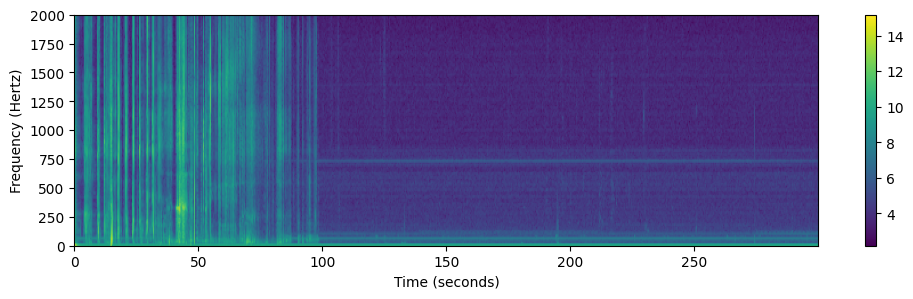

In [12]:
from matplotlib.pyplot import show, colorbar

# initialize the object with raw data from wav file
s = WavLTSA(r'Z:\Sounds\CMI_PalmyraReef_2023_R1_raw\6545\6545.181230085150.wav')

# some reasonable settings for a 44.1kHz sampling rate
params = {'div_len': 22050,
          'subdiv_len': 4096,
          'nfft': 4096,
          'noverlap': 1000}

plt.figure(figsize=(12,3))

# apply the parameters
s.set_params(params)

# compute the LTSA -- identical to s.compute()
s.compute()

# throw out data over 6kHz as there isn't much interesting activity there
# in a typical song
s.crop(fmax=2000, tmin=300)
s.show()

colorbar()
show()

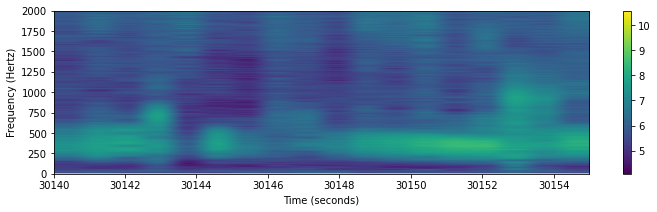

In [ ]:
from matplotlib.pyplot import show, colorbar

# initialize the object with raw data from wav file
s = WavLTSA('/content/drive/MyDrive/CMI_test_LTSA/6532.220701204642.wav')

# some reasonable settings for a 44.1kHz sampling rate
params = {'div_len': 22050,
          'subdiv_len': 4096,
          'nfft': 4096,
          'noverlap': 1000}

plt.figure(figsize=(12,3))


# apply the parameters
s.set_params(params)

# compute the LTSA -- identical to s.compute()
s.compute()

# throw out data over 2kHz as there isn't much interesting activity there
s.crop(fmax=2000, tmin=30140,tmax=30155)
s.show()

colorbar()
show()

In [ ]:
!ls /content/drive/MyDrive/CMI_test_LTSA/

24F3190160371DB1_20220116_111038.WAV  6532.220701204642.wav


In [ ]:
!pip list

Package                       Version
----------------------------- ----------------------
absl-py                       1.3.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.3
aiosignal                     1.2.0
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
asynctest                     0.13.0
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.10.3
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.9
bokeh